In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#General packages
import pandas as pd
import numpy as np
import pickle
import scipy.stats
from scipy.stats import norm
import scipy as sp

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
# Build figures inline
%matplotlib inline

#NLP packages
import re
import nltk
from wordcloud import WordCloud

#Text preprocessing packages
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Import scikit-learn tools, vectorizers, transformer, and classifiers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

# import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#Cross validation packages for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [2]:
#load pickled files to DataFrame
grocery_foods = pd.read_pickle('../input/grocery-foods-statspkl/grocery_foods_stats.pkl')
grocery_foods.head(2)

,reviewText,rating,review_summary
0,Just another flavor of Kit Kat but the taste i...,4,Good Taste
1,I bought this on impulse and it comes from Jap...,3,"3.5 stars, sadly not as wonderful as I had hoped"


In [3]:
# Labeling the dataset
# label: 1 = high rating (rating = 5), label: 0 = low rating (not5)

def label_func(rating):
    if rating == 5:
        return 1
    else:
        return 0

    
grocery_foods['label_food'] = grocery_foods['rating'].apply(label_func) # labeling  grocery_foods dataset
grocery_foods.head(2)

,reviewText,rating,review_summary,label_food
0,Just another flavor of Kit Kat but the taste i...,4,Good Taste,0
1,I bought this on impulse and it comes from Jap...,3,"3.5 stars, sadly not as wonderful as I had hoped",0


### Text Pre-Processing to reduce document dimension

- Remove URL.
- Remove numbers and Punctuation
- Convert all characters into lowercase
- Tokenization
- Remove Stopwords
- Lemmatization
- convert list of tokens back into the string

In [4]:
# Remove non-English using NLTK

words = set(nltk.corpus.words.words())

def remove_non_en(text):
    text = " ".join(w.lower() for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())
    return text


grocery_foods['clean_review_food'] = grocery_foods['reviewText'].apply(lambda x: remove_non_en(x)) # grocery_foods dataset
grocery_foods.head(2)

,reviewText,rating,review_summary,label_food,clean_review_food
0,Just another flavor of Kit Kat but the taste i...,4,Good Taste,0,just another flavor of kit kat but the taste i...
1,I bought this on impulse and it comes from Jap...,3,"3.5 stars, sadly not as wonderful as I had hoped",0,i bought this on impulse and it comes from jap...


In [5]:
# Preprocessing
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

def text_preprocessing(review):
    review = re.sub(r'http\S+', '', review)   # removing URL
    review = re.sub('[^a-zA-Z]', ' ', review) # keep only alpha (removing numbers and punctions)
    review = str(review).lower()              # Lowercase all text
    review = word_tokenize(review)            # Tokenization
    review = [w for w in review if w not in stop_words] # Removing Stopwords
    review = [lemma.lemmatize(word=w, pos='v') for w in review] # Lemmatization
    review = ' '.join(review)
    return review

grocery_foods['clean_review_food'] = grocery_foods['clean_review_food'].apply(text_preprocessing) # grocery_foods preprocessing
grocery_foods.head(2)



,reviewText,rating,review_summary,label_food,clean_review_food
0,Just another flavor of Kit Kat but the taste i...,4,Good Taste,0,another flavor kit kat taste unique bite diffe...
1,I bought this on impulse and it comes from Jap...,3,"3.5 stars, sadly not as wonderful as I had hoped",0,buy impulse come japan amuse family weird pack...


## Machine Learning on Grocery_foods Dataset


### Create X and y, split train and test data sets

In [6]:
# store the feature matrix (X) and response vector (y) of dataset
# uppercase X because it's an m x n matrix
# lowercase y because it's a m x 1 vector

X_food = grocery_foods.clean_review_food
y_food = grocery_foods.label_food

print(X_food.shape)
print(y_food.shape)

(151054,)
(151054,)


In [7]:
# split the data into training and test sets
X_train_food, X_test_food, y_train_food, y_test_food = train_test_split(X_food, y_food, random_state=42, test_size=0.3)

# Show the results of the split
print("X Training set sample size:", (X_train_food.shape[0]))
print("X Testing set sample size:", (X_test_food.shape[0]))
print("y Training set sample size:", (y_train_food.shape[0]))
print("y Testing set sample size:", (y_test_food.shape[0]))

X Training set sample size: 105737
X Testing set sample size: 45317
y Training set sample size: 105737
y Testing set sample size: 45317


### Vectorize, fit, create document-term matrix with two vectorizers

In [8]:
# Instantiate CountVectorizer and TfidfVectorizer
vect = CountVectorizer(min_df=1, ngram_range=(1, 2)) 
tfidf = TfidfVectorizer(min_df=1, ngram_range=(1, 2))

In [9]:
# Apply CountVectorizer to learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train_food)

# examine the document-term matrix
X_train_dtm

<105737x1076580 sparse matrix of type '<class 'numpy.int64'>'
	with 7108227 stored elements in Compressed Sparse Row format>

In [10]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test_food)
X_test_dtm

<45317x1076580 sparse matrix of type '<class 'numpy.int64'>'
	with 2784332 stored elements in Compressed Sparse Row format>

In [11]:
# Apply TfidfVectorizer to learn training data vocabulary,then use it to create a document-term matrix
X_train_tfidf_food = tfidf.fit_transform(X_train_food)

# transform testing data with tfidif vectorizer into document-term matrix
X_test_tfidf_food = tfidf.transform(X_test_food)
X_test_tfidf_food

<45317x1076580 sparse matrix of type '<class 'numpy.float64'>'
	with 2784332 stored elements in Compressed Sparse Row format>

### Build baseline model with Naive Bayes and compare vectorizers

In [12]:
# Instantiate MultinomialNB() classifier for CountVectorizer
nb = MultinomialNB(alpha=1, fit_prior=True)

# Train model
nb.fit(X_train_dtm, y_train_food)

# Make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# Calculate F1 Score
f1 = metrics.f1_score(y_test_food, y_pred_class)

# Confusion matrix
cm = metrics.confusion_matrix(y_test_food, y_pred_class)

# Calculate predicted probabilities for X_test_dtm
y_pred_prob = nb.predict_proba(X_test_dtm)[:,1]

# Calculate AUC for Naive Bayes model with CountVec
auc = metrics.roc_auc_score(y_test_food, y_pred_class)

print(vect)
print('\nF1 Score: ', f1)
print('\nConfusion Matrix:\n', cm)
print('\nAUC: ', auc)

CountVectorizer(ngram_range=(1, 2))

F1 Score:  0.8027973601319934

Confusion Matrix:
 [[13390  5838]
 [ 4680 21409]]

AUC:  0.7584971653297047


From the confusion matrix we can see, using CountVectorizer, at baseline the Naive Bayes model 21409 reviews were correctly predicted as 'five' (positive) ratings (TP) and 13390 were correctly predicted as 'not5' (negative) ratings (TN).
However, 5838 reviews were incorrectly predicted to be 'five' (positive) ratings (FP:Type I error) and 4680 reviews were incorrectly predicted to be 'not5' (negative) ratings (FN: Type II error). 

Let's compare it with the TfidfVectorizer.

In [13]:
# COMPARE TFIDF VECTORIZER

# instantiate MultinomialNB() classifier to use on tfidf vectors
nb_tfidf = MultinomialNB(alpha=1, fit_prior=True)

# train the model 
nb_tfidf.fit(X_train_tfidf_food, y_train_food)

# Make class predictions for X_test_tidf_baby
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf_food)

# Calculate F1 Score
f1 = metrics.f1_score(y_test_food, y_pred_tfidf)

# Confusion matrix
cm = metrics.confusion_matrix(y_test_food, y_pred_tfidf)

# Calculate predicted probabilities for Xtest1
y_prob_tfidf = nb_tfidf.predict_proba(X_test_tfidf_food)[:,1]

# Calculate AUC for Naive Bayes model with Tfidf
auc = metrics.roc_auc_score(y_test_food, y_prob_tfidf)

print(tfidf)
print('\nF1 Score: ', f1)
print('\nConfusion Matrix:\n', cm)
print('\nAUC: ', auc)

TfidfVectorizer(ngram_range=(1, 2))

F1 Score:  0.7988509415895307

Confusion Matrix:
 [[ 7685 11543]
 [ 1061 25028]]

AUC:  0.8386822507914712


From the confusion matrix we can see, using TFIDF Vectorizer, at baseline the Naive Bayes model 25028 reviews were correctly predicted as 'five' (positive) ratings (TP) and 7685 were correctly predicted as 'not5' (negative) ratings (TN). However, 11543 reviews were incorrectly predicted to be 'five' (positive) ratings (FP) and 1061 reviews were incorrectly predicted to be 'not5' (negative) ratings but they are 'five'(FN).
The TfidfVectorizer with default settings did better in predicting high ratings ('five') but did poorly for low ones ('not5'). Parameters definitely need to be tuned.

### Picking Hyperparameters

I want to look at the __alpha__, __min_df__ and __fit_prior__ to see if I can make the model better.

#### min_df:




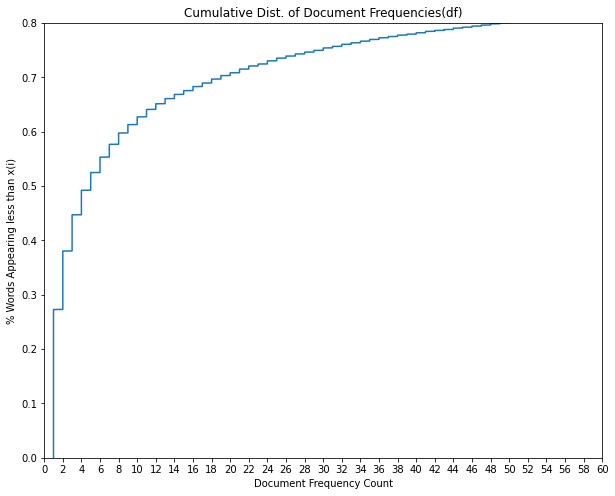

In [14]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train_food) 
X = X.tocsc() 


#  to get a count of documents in which a word has appeared, sum it across rows
df = np.sum(X>0,axis=0).tolist()[0]

x_df = np.sort(df)
y_df = np.arange(1, len(df) + 1)/len(df)

fig, ax = plt.subplots(figsize=(10,8))
_ = plt.plot(x_df, y_df)
_ = plt.xlim([0,30])
_ = plt.ylim([0, .8])
_ = plt.xticks([x for x in range(0,62,2)])
_ = plt.title('Cumulative Dist. of Document Frequencies(df)')
_ = plt.xlabel('Document Frequency Count')
_ = plt.ylabel('% Words Appearing less than x(i)')

plt.show()

In [15]:
# best min_df for CountVectorizer

values_dict = {}
pos_df = [ .1, 1, 2, 3, 4,5]

for min_df in pos_df:
    vect = CountVectorizer(min_df=min_df, ngram_range=(1, 2)) 
    X_train_dtm = vect.fit_transform(X_train_food)
    X_test_dtm = vect.transform(X_test_food)
    nb = MultinomialNB(alpha=1, fit_prior=True)
    nb.fit(X_train_dtm, y_train_food)
    y_pred_class = nb.predict(X_test_dtm)
    f1 = metrics.f1_score(y_test_food, y_pred_class)
    y_pred_prob = nb.predict_proba(X_test_dtm)[:,1]
    auc = metrics.roc_auc_score(y_test_food, y_pred_class)
    values_dict[auc] = [f1, min_df]
    print("AUC: {}, Min_df: {}, F1: {:4f}".format(auc, min_df, f1))
    
best_auc = max(values_dict.keys())
best_f1 = values_dict[max(values_dict.keys())][0]
best_min_df = values_dict[max(values_dict.keys())][1]
print('\n Best Values: \n Min_df: {}, AUC: {}, F1: {:4f}'.format(best_min_df, best_auc, best_f1))

AUC: 0.646281469913246, Min_df: 0.1, F1: 0.727322
AUC: 0.7584971653297047, Min_df: 1, F1: 0.802797
AUC: 0.7585636005163647, Min_df: 2, F1: 0.801251
AUC: 0.7579090265919599, Min_df: 3, F1: 0.799917
AUC: 0.7575149187077634, Min_df: 4, F1: 0.799826
AUC: 0.7574983689674771, Min_df: 5, F1: 0.799494

 Best Values: 
 Min_df: 2, AUC: 0.7585636005163647, F1: 0.801251


In [16]:
# best min_df for TfidfVectorizer
values_dict = {}
pos_df = [.1, 1, 2, 3, 4, 5]

for min_df in pos_df:
    tfidf = TfidfVectorizer(min_df=min_df, ngram_range=(1, 2)) 
    X_train_tfidf_food = tfidf.fit_transform(X_train_food)
    X_test_tfidf_food = tfidf.transform(X_test_food)
    nb_tfidf = MultinomialNB(alpha=1, fit_prior=True)
    nb_tfidf.fit(X_train_tfidf_food, y_train_food)
    y_pred_tfidf = nb_tfidf.predict(X_test_tfidf_food)
    f1 = metrics.f1_score(y_test_food, y_pred_tfidf)
    y_prob_tfidf = nb_tfidf.predict_proba(X_test_tfidf_food)[:,1]
    auc = metrics.roc_auc_score(y_test_food, y_prob_tfidf)
    values_dict[auc] = [f1, min_df]
    print("AUC: {}, Min_df: {}, F1: {:4f}".format(auc, min_df, f1))

best_auc = max(values_dict.keys())
best_f1 = values_dict[max(values_dict.keys())][0]
best_min_df = values_dict[max(values_dict.keys())][1]
print('\n Best Values: \n Min_df: {}, AUC: {}, F1: {:4f}'.format(best_min_df, best_auc, best_f1))

AUC: 0.7069235188618359, Min_df: 0.1, F1: 0.743610
AUC: 0.8386822507914712, Min_df: 1, F1: 0.798851
AUC: 0.841512399909854, Min_df: 2, F1: 0.811768
AUC: 0.8418509519385895, Min_df: 3, F1: 0.812399
AUC: 0.8413482660365449, Min_df: 4, F1: 0.812803
AUC: 0.8409463397855206, Min_df: 5, F1: 0.812856

 Best Values: 
 Min_df: 3, AUC: 0.8418509519385895, F1: 0.812399


Best min_df for CountVectorizer is 2 and for TfidfVectorizer is 3.

__Because of the computing limitation of my PC I will increase the min_df to 50 for both Vectorizers.__

### GridSearchCV

__Run GridSearchCV on best parameters for CountVectorizer__

In [17]:
# run this to get a list of the all available pipe-items unique keys for the grid parameters
sorted(nb.get_params().keys())

['alpha', 'class_prior', 'fit_prior']

In [18]:
# Create a list of parameters for tuning
parameters = {'fit_prior': (True, False),
              'alpha': (0.001, 0.01, 0.1, 1, 5, 10),
             }

In [19]:
# Instantiate Vectorizer with new min_df 
vect = CountVectorizer(min_df=50, ngram_range=(1, 2)) 

# Apply CountVectorizer to learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train_food)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test_food)

# Perform GridSearch on Naive Bayes using the given parameters and CountVectorizer
gs_count = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', cv=5)
gs_count.fit(X_train_dtm, y_train_food)

# View the best score (set to roc_auc) for MultinomialNB with CountVect
print(gs_count)
print('\nBest Score: ', gs_count.best_score_)

# Get best parameters for MultinomialNB with CountVect
print('Best parameters:', gs_count.best_params_)
# Alpha = 1 is the default and picked as best alpha
# fit_prior: True (default)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': (0.001, 0.01, 0.1, 1, 5, 10),
                         'fit_prior': (True, False)},
             scoring='roc_auc')

Best Score:  0.8198415851419151
Best parameters: {'alpha': 0.1, 'fit_prior': False}


__Run GridSearchCV on best parameters for TfidfVectorizer__

In [20]:
# Instantiate Vectorizer with new min_df 
tfidf = TfidfVectorizer(min_df=50, ngram_range=(1, 2))

# Apply TfidfVectorizer to learn training data vocabulary,then use it to create a document-term matrix
X_train_tfidf_food = tfidf.fit_transform(X_train_food)

# transform testing data with tfidif vectorizer into document-term matrix
X_test_tfidf_food = tfidf.transform(X_test_food)


# Perform GridSearch on Naive Bayes using the given parameters and CountVectorizer
gs_tfidf = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', cv=5)
gs_tfidf.fit(X_train_tfidf_food, y_train_food)

# View the best score (set to roc_auc) for MultinomialNB with TfidfVect
print(gs_tfidf)
print('\nBest Score: ', gs_tfidf.best_score_)

# Get best parameters for MultinomialNB with TfidfVect
print('Best parameters:', gs_tfidf.best_params_)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': (0.001, 0.01, 0.1, 1, 5, 10),
                         'fit_prior': (True, False)},
             scoring='roc_auc')

Best Score:  0.8345236976974524
Best parameters: {'alpha': 5, 'fit_prior': True}


__Interpretation:__

The Naive Bayes model using a minimum document frequency of 50 for CountVectorizer and TfidfVectorizer performs well. GridSearchCV indicated that the best parameters for TfidfVectorizer were 'alpha': 5, 'fit_prior': False but for CountVectorizer it was different ('alpha': 0.1, 'fit_prior': True). For further algorithms I will continue to use the TfidfVectorizer because it provided slightly better results.
Next I will look further into the text to further improve the model amongst other algorithms and classifiers.

In [21]:
# Calculate predicted probabilities for X_test_tfidf_food
y_prob_nb = gs_tfidf.predict_proba(X_test_tfidf_food)[:,1]

# Calculate AUC for Naive Bayes model with TfidfVectorizer
auc = metrics.roc_auc_score(y_test_food, y_prob_nb)

print('AUC: ', auc)

AUC:  0.832488926126624


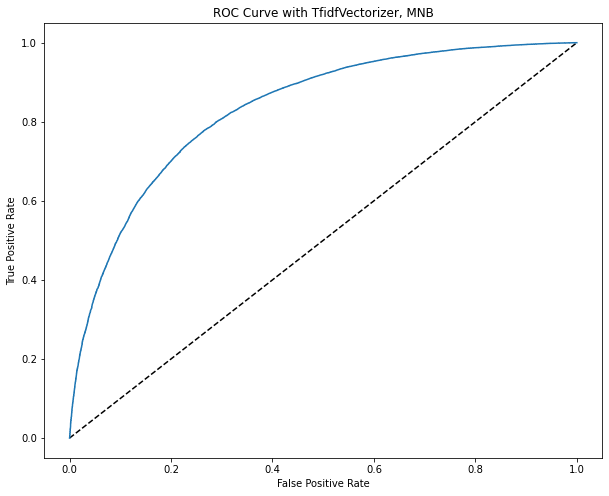

In [22]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_food, y_prob_nb)

# Plot ROC curve
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with TfidfVectorizer, MNB')
plt.show()

### Most Predictive Features

In [23]:
words = np.array(tfidf.get_feature_names())

# Create an identity matrix the length of the vocabulary
x = np.eye(X_test_tfidf_food.shape[1]) 

In [24]:
# Use the model to predict on the identity matrix, and get a list of probabilities for each word
probs = gs_tfidf.predict_log_proba(x)[:,0] 

In [26]:
# Sort for most/least probable words for any give class
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Positive words\t     P(five (positive) | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Negative words\t     P(five (positive) | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Positive words	     P(five (positive) | word)
    highly recommend 0.90
         great price 0.89
              highly 0.87
                hook 0.87
absolutely delicious 0.87
           glad find 0.87
           best ever 0.86
           wonderful 0.86
            far best 0.85
          best price 0.85
Negative words	     P(five (positive) | word)
              refund 0.23
            terrible 0.23
           plus side 0.22
           taste bad 0.22
         think stick 0.20
               worst 0.20
            one star 0.17
     nothing special 0.16
         reason give 0.16
           give four 0.16


### Fit other Classifiers with TFIDF Vectorizer

#### 1. Logistic Regression

In [27]:
# Setup the hyperparameter grid
param_grid = {'C': np.arange(0.05, 4, 0.8),
              'l1_ratio': [0, 1]
              }
# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(max_iter=1000)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs = -1)

# Fit it to the data
logreg_cv.fit(X_train_tfidf_food, y_train_food)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


Tuned Logistic Regression Parameters: {'C': 0.8500000000000001, 'l1_ratio': 0}
Best score is 0.8563376187888402


In [28]:
pred_log_clf = logreg_cv.predict(X_test_tfidf_food)

# Calculate F1 Score
metrics.f1_score(y_test_food, pred_log_clf)

0.8185458455377999

In [29]:
# Calculate Predicted Probabilities,# keep probabilities for the positive outcome only
pred_prob_log_clf = logreg_cv.predict_proba(X_test_tfidf_food)[:,1]

# Determine ROC Score
metrics.roc_auc_score(y_test_food, pred_prob_log_clf)

0.8557879722467994

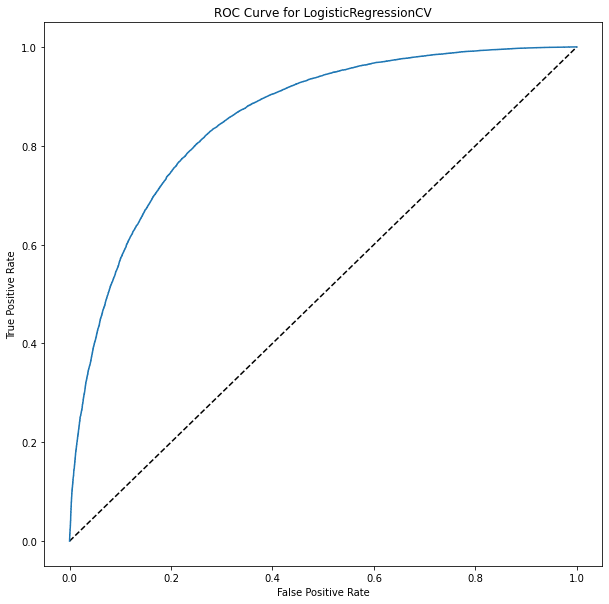

In [30]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_food, pred_prob_log_clf)

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV')
plt.show()

#### 2. Random Forest

In [48]:
# Instantiate and fit Random Forests Model
rf_clf = RandomForestClassifier(class_weight='balanced',n_jobs = -1).fit(X_train_tfidf_food, y_train_food)


pred_rf_clf = rf_clf.predict(X_test_tfidf_food)

# Calculate F1 Score
metrics.f1_score(y_test_food, pred_rf_clf)

0.7929713057295076

In [49]:
# Create the parameter grid
parameters = {'max_features': ['sqrt', 'auto'],
              'max_depth': [10, 50, None],
              'n_estimators': [50,100]
              }

# Instantiate the grid search model
gs_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced'), 
                     parameters, scoring='roc_auc', n_jobs=4, cv=3)

# Fit the grid search to the data
gs_rf.fit(X_train_tfidf_food, y_train_food)



/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=4,
             param_grid={'max_depth': [10, 50, None],
                         'max_features': ['sqrt', 'auto'],
                         'n_estimators': [50, 100]},
             scoring='roc_auc')

In [50]:
# Get best parameters and best accuracy score
print('Best Score: ', gs_rf.best_score_)
print('Best Parameters: ', gs_rf.best_params_)

Best Score:  0.8255344303546267
Best Parameters:  {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}


In [51]:
# calculate predicted probabilities # keep probabilities for the positive outcome only
pred_prob_rf_clf = gs_rf.predict_proba(X_test_tfidf_food)[:, 1]

In [52]:
# Determine ROC score
metrics.roc_auc_score(y_test_food, pred_prob_rf_clf)

0.8256250259997576

In [53]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_food, pred_prob_rf_clf)

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.plot(fpr, tpr, label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForestClassifier')
plt.show()

SyntaxError: invalid syntax (<ipython-input-53-c8b561e60a47>, line 6)

### Thresholding for best model based on different business situation

- Adjust threshold of best classifier which is Logistic Regression

- The default threshold for interpreting probabilities to class labels is 0.5
      Prediction < 0.5 = Class 0
      Prediction >= 0.5 = Class 1
- Procedure for Thresholding:
      1. Fit Model on the Training Dataset.
      2. Predict Probabilities on the Test Dataset.
      3. For each threshold in Thresholds:
            3a. Convert probabilities to Class Labels using the threshold.
            3b. Evaluate Class Labels.
            3c. If Score is Better than Best Score.
            3ci. Adopt Threshold.
      4. Use Adopted Threshold When Making Class Predictions on New Data.

__Scoring metrics:__ 
    
    - Precision 
    - Recall
    - Balanced Accuracy (Accuracy determined for imbalanced datasets)
    - f1-score

### I. __Business Case 1: Market Comparisons of the Grocery and Foods__

I will look at __balanced acccuracy__ and __confusion matrices__ to determined the best threshold to have best accuracy, and least number of false positives and false negatives.

In [31]:
# Create and print the confusion matrix for the LogReg Model
confusion_logreg = metrics.confusion_matrix(y_test_food, pred_log_clf)
print(confusion_logreg)
print('-'* 17)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

[[13452  5776]
 [ 4012 22077]]
-----------------
[['TN' 'FP']
 ['FN' 'TP']]


In [32]:
# Calculate balanced accuracy
balanced_accuracy_score(y_test_food, pred_log_clf)

0.772911727975248

In [33]:
# define thresholds
thresholds_a =np.arange(0,1,.01)

In [34]:
# apply threshold to positive probabilities to create labels
def to_labels(y_pred_prob, threshold):
    return (y_pred_prob >= threshold).astype('int')

In [35]:
balanced_accuracy_points = [balanced_accuracy_score(y_test_food, to_labels(pred_prob_log_clf, t)) for t in thresholds_a]

# get best threshold
ix1 = np.argmax(balanced_accuracy_points)

print('Best Threshold=%.3f' % (thresholds_a[ix1]))
print()
print('Highest Accuracy=%.5f'%(balanced_accuracy_points[ix1]))
print()
print(metrics.confusion_matrix(y_test_food, to_labels(pred_prob_log_clf, thresholds_a[ix1])))

Best Threshold=0.560

Highest Accuracy=0.77649

[[14488  4740]
 [ 5231 20858]]


The threshold level of 0.56 provides the best results with a balanced accuracy of 0.776. In total there are 9971 mispredictions, 5231 false negatives and 4740 false positives.



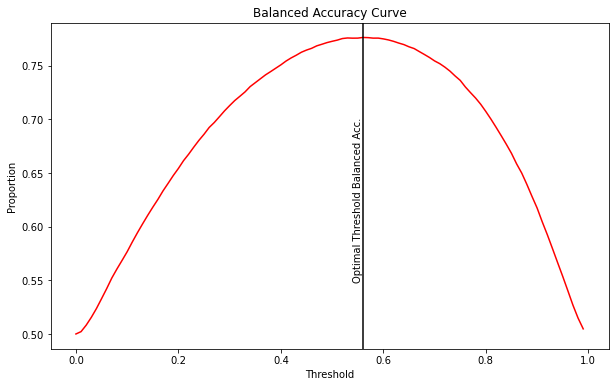

In [38]:
plt.figure(figsize=(10,6))
plt.plot(thresholds_a, balanced_accuracy_points, color='red')
plt.title('Balanced Accuracy Curve')

plt.xlabel('Threshold')

plt.axvline(x=.56, color='black')
plt.text(.54,.55,'Optimal Threshold Balanced Acc.',rotation=90)
plt.ylabel('Proportion')
plt.show()

### II. Business Case 2: Customer Satisfaction

For this case we will target the negative or low rated reviews because negative (low rated) reviews helps sellers to understand the issue and to improve their products and services. To measure this I will use F1-score because it is a better measure when focusing on a specific class in this case low ratings. 

In [39]:
# Calculate Precision and Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_food, pred_prob_log_clf)
thresholds = np.append(thresholds, 1)

In [40]:
# Define a function to apply threshold to positive probabilities to create labels
def to_labels(y_pred_prob, threshold):
    return (y_pred_prob >= threshold).astype('int')

In [42]:
# evaluate each threshold
scores = [metrics.f1_score(y_test_food, to_labels(pred_prob_log_clf, t), pos_label=0) for t in thresholds]

# get best threshold
ix = np.argmax(scores)

print('Best Threshold=%.3f, f1-Score=%.5f' % (thresholds[ix], scores[ix]))
print()
print('Classification_Report:')
print(metrics.classification_report(y_test_food, to_labels(pred_prob_log_clf, thresholds[ix])))




Best Threshold=0.599, f1-Score=0.74720

Classification_Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75     19228
           1       0.83      0.76      0.80     26089

    accuracy                           0.77     45317
   macro avg       0.77      0.78      0.77     45317
weighted avg       0.78      0.77      0.78     45317



The optimal threshold for this case is 0.599 with f1_score of 0.747.


Now lets plot the Precision, Recall and f1-Score on a graph together.

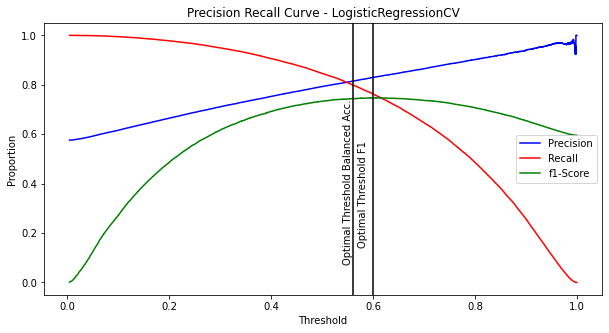

In [47]:
# Plot Precision, Recall and f1-Score on a graph together.

plt.figure(figsize=(10,5))
plt.plot(thresholds, precision, color='blue')
plt.plot(thresholds, recall, color='red')
plt.plot(thresholds, scores, color='green')
plt.title('Precision Recall Curve - LogisticRegressionCV')
plt.legend(('Precision', 'Recall', 'f1-Score'), loc='center right')
plt.xlabel('Threshold')
plt.ylabel('Proportion')
plt.axvline(x=.599, color='black')
plt.text(.57,.15,'Optimal Threshold F1',rotation=90)
plt.axvline(x=.56, color='black')
plt.text(.54,.08,'Optimal Threshold Balanced Acc.',rotation=90)
plt.show()

